In [17]:
# Zadanie 1 - przygotowanie danych z poprzedniej listy 
import pandas as pd
import numpy as np

data5 = pd.read_csv("Titanic Dataset.csv")

advanced_data = data5.copy()
advanced_data['cabin'] = advanced_data['cabin'].notnull().astype(int)
def extract_title(name):
    title_mapping = {
        'Mr.' : 'Mr.', 'Ms.' : 'Ms.', 'Miss.' : 'Miss.',
        'Col.' : 'Col.', 'Mrs.' : 'Mrs.', 'Dr.' : 'Dr.',
        'Major.' : 'Major.', 'Master.' : 'Master.', 'Capt.' : 'Capt.'
    }
    for title in title_mapping:
        if title in name:
            return title_mapping[title]
    return 'Other.'

advanced_data['title'] = advanced_data['name'].apply(extract_title)
title_age_median = advanced_data.groupby('title')['age'].median()
for title in advanced_data['title'].unique():
    mask = (advanced_data['age'].isnull()) & (advanced_data['title'] == title)
    advanced_data.loc[mask, 'age'] = title_age_median[title]

high_missing_cols = ['boat', 'body', 'home.dest']
advanced_data = advanced_data.drop(columns=high_missing_cols)
numeric_cols_empty = ['fare']
for col in numeric_cols_empty:
    mean = advanced_data[col].mean()
    advanced_data[col] = advanced_data[col].fillna(mean)

categoric_cols_empty = ['embarked']
for col in categoric_cols_empty:
    freq_val = advanced_data[col].mode()[0]
    advanced_data[col] = advanced_data[col].fillna(freq_val)

Y = advanced_data['survived']
X = advanced_data.drop('survived', axis = 1)
numeric_columns = X.select_dtypes(include=[np.number]).columns
categorical_columns = X.select_dtypes(include=['object']).columns
#X_categorical = pd.get_dummies(X[categorical_columns], drop_first=True)
X_categorical = X[categorical_columns]
X_numeric = X[numeric_columns]
X = pd.concat([X_numeric, X_categorical], axis=1)



In [22]:
from sklearn.cluster import KMeans
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
# Zadanie 1 - konkrety

# 3 metody kwantyfikacji zmiennych:
# 1. Podzielenie zakresu zmiennych na równe części
def divide1(X_num, k, bins=None):
    X1 = X_num.copy()
    new_bins = {}
    for col in X1.columns:
        if bins is None:
            # Tryb treningowy
            X1[col], bin_edges = pd.cut(X1[col], bins=k, labels=False, retbins=True)
            new_bins[col] = bin_edges
        else:
            # Tryb testowy
            bin_edges = bins[col]
            X1[col] = pd.cut(X1[col], bins=bin_edges, labels=False, include_lowest=True)
    if bins is None:
        return X1, new_bins
    else:
        return X1, None

        # labels=False sprawi że zwrócone będą labele tych etykiet, zatem zamiast numerycznych
        # wartości mamy teraz label grupy do której wartość należy

# 2. Podzielenie obserwacji na równoliczne części
def divide2(X_num, k, quantiles=None):
    X2 = X_num.copy()
    new_quantiles = {}
    for col in X2.columns:
        if quantiles is None:
            # Tryb treningowy
            X2[col], bin_edges = pd.qcut(X2[col], q=k, labels=False, retbins=True, duplicates='drop')
            new_quantiles[col] = bin_edges
        else:
            # Tryb testowy
            bin_edges = quantiles[col]
            X2[col] = pd.cut(X2[col], bins=bin_edges, labels=False, include_lowest=True)
    if quantiles is None:
        return X2, new_quantiles
    else:
        return X2, None

# 3. Klasteryzacja wartości każdej zmiennej
def divide3(X_num, k, kmeans_models=None):
    X3 = X_num.copy()
    new_models = {}
    for col in X3.columns:
        data = X3[col].values.reshape(-1, 1) 
        # zamieniamy naszą kolumne (w postaci po prostu listy), na prawdziwa kolumne 2D,
        # gdzie kazda wartosc to jeden rzad - kmeans potrzebuje danych 2D do klasteryzacji
        if kmeans_models is None: # tryb treningowy
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            # n_init to liczba uruchomiec z roznymi punktami startowymi i wybor najlepszego rezultatu
            clusters = kmeans.fit_predict(data)
            # fit_predict trenuje model i przypisuje punkty do klastrów
            new_models[col] = kmeans
        else: # tryb testowy 
            kmeans = kmeans_models[col]
            clusters = kmeans.predict(data)
        X3[col] = clusters
        # przypisujemy etykiety klastrow do wierszy, zamiast ich wartosci numerycznych
    return X3, new_models


# Tworzenie modeli
results = []
k_values = [2, 5, 10, 25]
X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_numeric, Y, test_size=0.2, random_state=42
)

for k in k_values:
    print(f"\n--- Testowanie dla k = {k} ---")
    for i, f_kwant in enumerate([divide1, divide2, divide3]):
        if i == 0:  
            X_train_quantized, bins_dict = f_kwant(X_train_num, k)
            X_test_quantized, _ = f_kwant(X_test_num, k, bins_dict)
        elif i == 1: 
            X_train_quantized, quantiles_dict = f_kwant(X_train_num, k)
            X_test_quantized, _ = f_kwant(X_test_num, k, quantiles_dict)
        else: 
            X_train_quantized, kmeans_models = f_kwant(X_train_num, k)
            X_test_quantized, _ = f_kwant(X_test_num, k, kmeans_models)

        model = CategoricalNB()
        model.fit(X_train_quantized, y_train)

        y_pred = model.predict(X_test_quantized)
        accuracy = accuracy_score(y_test, y_pred)

        results.append({'method' : i, 'k' : k, 'accuracy' : accuracy})
        print(f"Metoda {i}: {accuracy:.4f}")



--- Testowanie dla k = 2 ---
Metoda 0: 0.6641
Metoda 1: 0.5992
Metoda 2: 0.6679

--- Testowanie dla k = 5 ---
Metoda 0: 0.6947
Metoda 1: 0.6756
Metoda 2: 0.6947

--- Testowanie dla k = 10 ---
Metoda 0: 0.7061
Metoda 1: 0.6641
Metoda 2: 0.7023

--- Testowanie dla k = 25 ---
Metoda 0: 0.6985
Metoda 1: 0.6641
Metoda 2: 0.6870


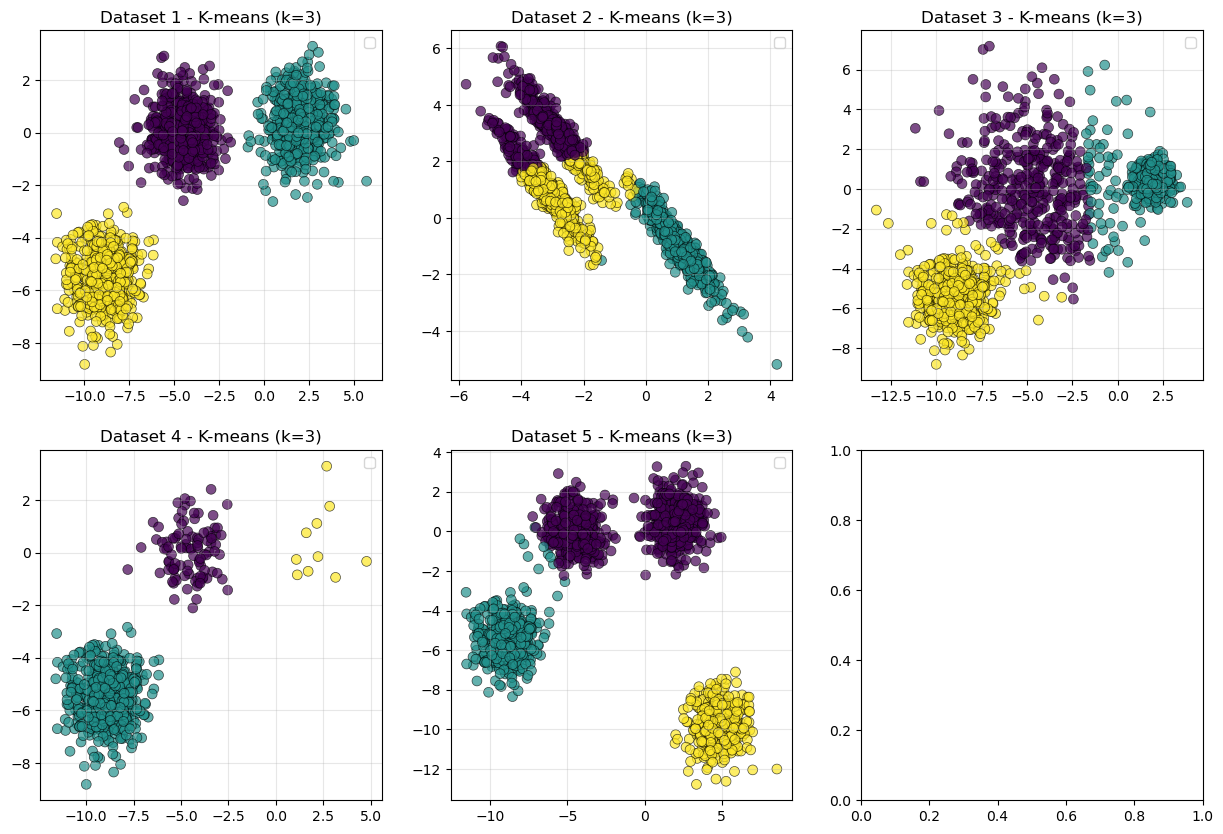

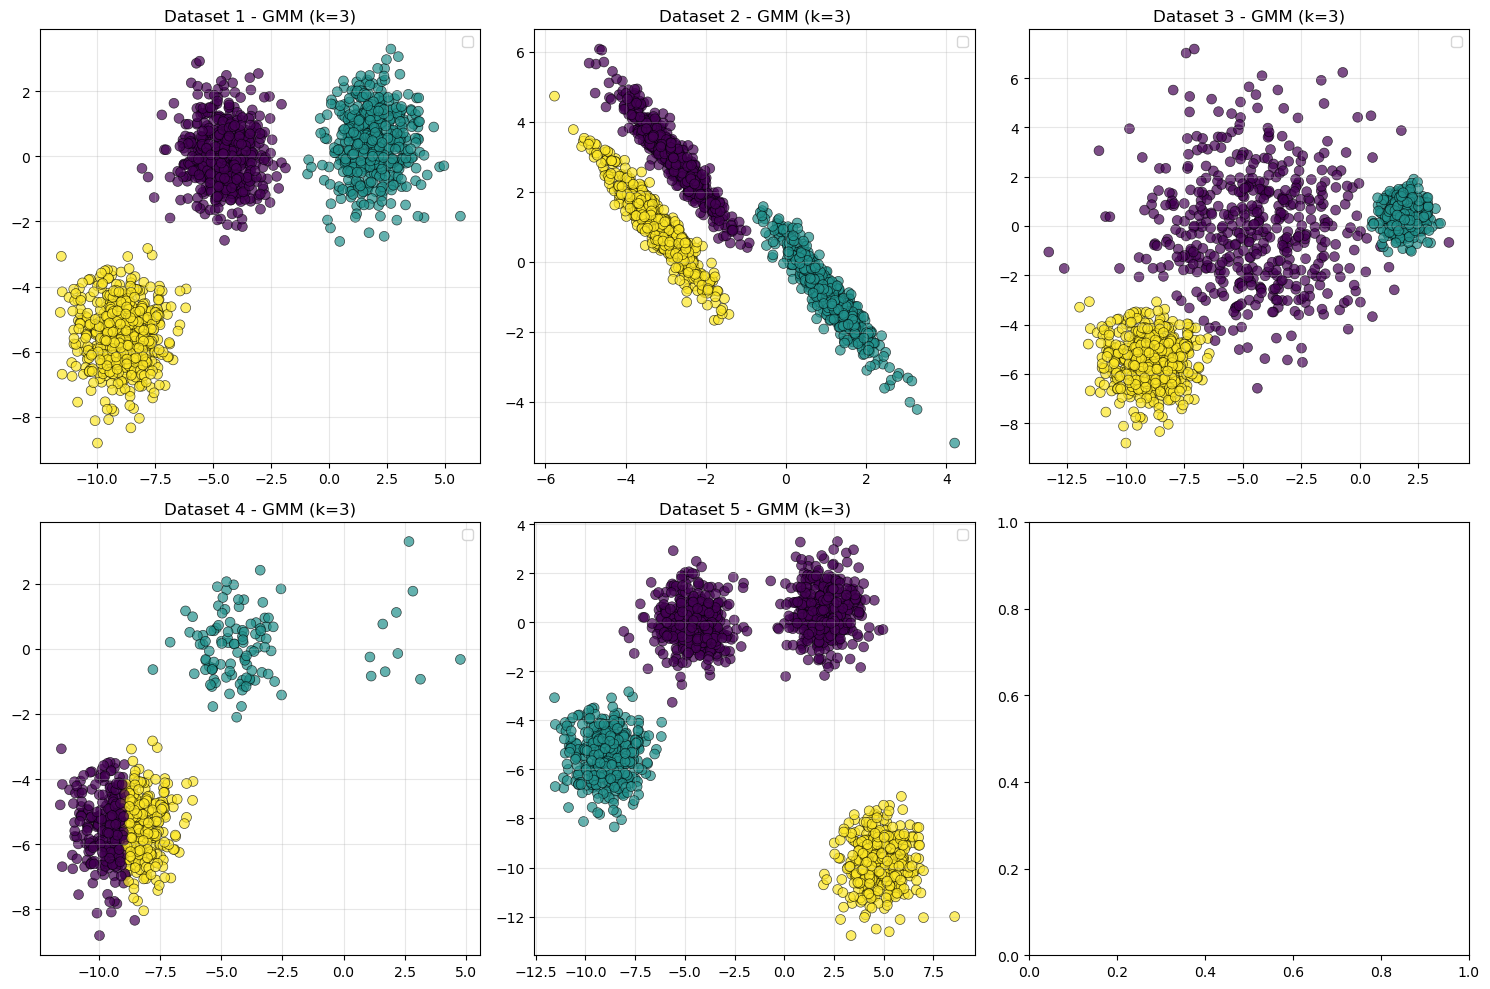

In [27]:
# Zadanie 2
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


data1 = np.load('data1.npy')
data2 = np.load('data2.npy')
data3 = np.load('data3.npy')
data4 = np.load('data4.npy')
data5 = np.load('data5.npy')

D = [data1, data2, data3, data4, data5]
k = 3
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
axes2 = axes2.ravel()

for i, data in enumerate(D):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data)
    gmm = GaussianMixture(n_components=k, random_state=42)
    clusters2 = gmm.fit_predict(data)

    scatter = axes[i].scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', 
                             alpha=0.7, s=50, edgecolor='black', linewidth=0.5)
    axes[i].set_title(f'Dataset {i+1} - K-means (k={k})')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()


    scatter2 = axes2[i].scatter(data[:, 0], data[:, 1], c=clusters2, cmap='viridis', 
                             alpha=0.7, s=50, edgecolor='black', linewidth=0.5)
    axes2[i].set_title(f'Dataset {i+1} - GMM (k={k})')
    axes2[i].grid(True, alpha=0.3)
    axes2[i].legend()

plt.tight_layout()
plt.show()

# KMeans dziala na zasadzie odleglosci i dlatego nie radzi sobie dla data2


In [41]:
# Zadanie 3 - wyliczenie klastrów
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

embeddings = np.load('image_emb.npy', allow_pickle=True)
labels = np.load('image_labels.npy', allow_pickle=True)
test_embeddings = np.load('image_emb_test.npy', allow_pickle=True)
test_labels = np.load('image_labels_test.npy', allow_pickle=True)
# print(np.unique(labels))
k = 10

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(embeddings)
test_clusters = kmeans.predict(test_embeddings)





In [46]:
from sklearn.metrics import accuracy_score

cluster_to_label = {}
for cluster_id in range(k):
    mask = (train_clusters == cluster_id) & (labels != '')
    cluster_labels = labels[mask]
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
    most_common_label = unique_labels[np.argmax(counts)]
    cluster_to_label[cluster_id] = most_common_label
    
predicted_labels = [cluster_to_label[cluster_id] for cluster_id in test_clusters]
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"\nDokładność na zbiorze testowym: {accuracy:.4f}")



Dokładność na zbiorze testowym: 0.7693
